# Disks and Accretion Computational Project

David Konijn

12484725

25/03/2022


In [2]:
import disklab
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as sps
import scipy.optimize as spopt
import matplotlib as mpl

from disklab import DiskRadialModel
from disklab.natconst import MS, year, au, RS, GG, cc
from solvediffonedee import *
from tqdm import tqdm

## Computing Set 1

The goal of this computing set is to solve the disk conservation equations as a function of radius and time. We start of by checking convergence to a steady state disk, in absence of viscosity variations. 

The first step is to produce the numerical disk calculation based on the differential equations we have seen in class. Specifically the mass conservation equation, the angular momentum conservation equation and the energy conservation equation: $$\frac{\partial \Sigma}{\partial t} = \frac{1}{2 \pi R} \frac{\partial \dot{M}}{\partial R},$$ $$\dot{M} = 6 \pi R^{1/2} \frac{\partial}{\partial R} (R^{1/2} \nu \Sigma), \text{and}$$ $$\frac{\partial \Sigma}{\partial t} = \frac{3}{R} \frac{\partial}{\partial R}(R^{1/2} \frac{\partial}{\partial R} (R^{1/2} \nu \Sigma) ).$$ For a constant input $\dot{M}$ at the outer radius, we will show that the simulation converges on the expected steady-state distribution of $\Sigma(R)$. We can calculate $\Sigma(R)$ numerically and compare it to the analytical solution we derived in class. As a second step, we will be incorporating different physical opacity prescriptions, allowing us to obtain the scale-height $H/R$ self-consistently from solving the viscous heating for the disk.

### Comparing the numerical solution with the analytical solution

In [3]:
def analytical_sigma(nu,mdot,rstar, r):
    """ calculates and returns the surface density as a function of r analytically 
    :param nu: the viscosity parameter
    :param mdot: the accretion rate parameter
    :param rstar: the radius parameter of the star
    :param r: the input array or single value for the radial component r
    :return: surface density
    """
    return (1/nu) * (mdot/(3*np.pi)) * (1-(rstar/r)**0.5)

def rg(mass):
    """ calculates the gravitational radius for a certain mass
    :param mass: mass of the object
    :return: the gravitational radius of the object
    """
    return (GG*mass)/(cc**2)

def FRK_sigma(alpha, mdot, m1, r, f):
    """the analytical solution for the surface density from Frank Rayne and King
    :param alpha: the 'ignorance' alpha parameter
    :param mdot: the accretion rate parameter
    :param m1: the mass of the object
    :param r: the radial distance from the object
    :param f: the parameter for the function (1-(rs/r)^0.5)^0.25
    :return: the analytically determined surface density 
    """
    return 5.2 * alpha**(-4/5) * mdot**(7/10) * m1**(1/4) * r**(-3/4) * f**(14/5)

def FRK_Tc(alpha, mdot, m1, r, f):
    """the analytical solution for the central temperature from Frank Rayne and King
    :param alpha: the 'ignorance' alpha parameter
    :param mdot: the accretion rate parameter
    :param m1: the mass of the object
    :param r: the radial distance from the object
    :param f: the parameter for the function (1-(rs/r)^0.5)^0.25
    :return: the analytically determined central temperature 
    """
    return (1.4*10**4) * alpha**(-1/5) * mdot**(3/10) * m1**(1/4) * r**(-3/4) * f**(6/5)

def FRK_rho(alpha, mdot, m1, r, f):
    """the analytical solution for the mid-plane density from Frank Rayne and King
    :param alpha: the 'ignorance' alpha parameter
    :param mdot: the accretion rate parameter
    :param m1: the mass of the object
    :param r: the radial distance from the object
    :param f: the parameter for the function (1-(rs/r)^0.5)^0.25
    :return: the analytically determined mid-plane density
    """
    return (3.1*10**(-8)) * alpha**(-7/10) * mdot**(11/20) * m1**(5/8) * r**(-15/8) * f**(11/5)

def FRK_nu(alpha, mdot, m1, r, f):
    """the analytical solution for the kinematic viscosity from Frank Rayne and King
    :param alpha: the 'ignorance' alpha parameter
    :param mdot: the accretion rate parameter
    :param m1: the mass of the object
    :param r: the radial distance from the object
    :param f: the parameter for the function (1-(rs/r)^0.5)^0.25
    :return: the analytically determined kinematic viscosity
    """
    return (1.8*10**14) * alpha**(4/5) * mdot**(3/10) * m1**(-1/4) * r**(3/4) * f**(6/5)

def FRK_H_div_R(alpha, mdot, m1, r, f):
    """the analytical solution for the H/R parameter from Frank Rayne and King
    :param alpha: the 'ignorance' alpha parameter
    :param mdot: the accretion rate parameter
    :param m1: the mass of the object
    :param r: the radial distance from the object
    :param f: the parameter for the function (1-(rs/r)^0.5)^0.25
    :return: the analytically determined H/R parameter
    """
    return (1.7*10**8) * alpha**(-1/10) * mdot**(3/20) * m1**(-3/8) * r**(1/8) * f**(3/5)

def FRK_fit(r, a, b, c, d, e, f):
    """ the FRK function to fit to the different parameter curves, to get the power-indices
    :param r: the radial distance in the disk from the central object
    :param a: the constant in front of the equation
    :param b: the power-law index of the alpha parameter
    :param c: the power-law index of the mdot parameter
    :param d: the power-law index of the m1 parameter
    :param e: the power-law index of the R parameter
    :param f: the power-law index of the f parameter
    :return: the value or array which this function returns
    """
    return (a) * (0.5**(b)) * (((((1e-10) * 2 * 10 * MS)/(year))/(10**16))**(c)) * (10**(d)) * ((r/(10**10))**(e)) * (((1-((6*rg(10*MS))/r)**0.5)**0.25)**(f))

def solution_for_opacity(model, mass, r_out, r_in, alpha_parm, mdot):
    """ shows the converging distribution solutions for Sigma_g, T_c, rho, nu, and H/R 
        the function takes as input a model, the mass, r_out, r_in, alpha_parm, and mdot 
    :param model: input opacity law name
    :param mass: mass of the black hole 
    :param r_out: outer disk radius
    :param r_in: inner disk radius
    :param alpha_parm: the ignorance alpha parameter
    :parm mdot: the accretion rate
    """

    var_list = [r'$\Sigma_g$',r'$T_c$',r'$\rho$',r'$\nu$',r'$H/R$']
    lim_list = [(1e1, 2e4),(5e4, 5e7),(1e-5, 1e0),(1e9, 1e13),(9e-5, 8e-3)]

    #we create our disk again, using physical units
    d = DiskRadialModel(mstar = mass, rout=r_out, rin = r_in, alpha=alpha_parm, nr = 10000)
    #for the more 'dramatic' fill-up effect, sigma has been set to practically 0 everywhere at t=0
    d.sigma = np.array([1] * 10000) * 1e-20

    d.meanopacitymodel = [model]
    d.compute_mean_opacity()

    ntime = 100
    tstart = 10000
    tend   = 10*year
    time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,30))
    plt.subplots_adjust(hspace=0.3)

    #for each timestep we update the parameters for the disk
    for itime in tqdm(range(1, ntime + 1)):
        d.sigma = d.get_viscous_evolution_next_timestep(
            time[itime] - time[itime - 1], sigma_innerbc = d.sigma[1]/2., mdot_outerbc = mdot)

        #update the temperature, scale-height, soundspeed, midplane density and opacity 
        d.compute_disktmid(vischeat=True,simple=True)
        d.compute_cs_and_hp()
        d.compute_rhomid_from_sigma()
        d.compute_mean_opacity()

        var_num_list = [d.sigma, d.tmid, d.rhomid, d.nu, d.hp/(d.r)]
        #for each paramter, plot the distributions for different timesteps 
        for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
            ax.plot(d.r/rg(10*MS), var_num_list[i], c='k', alpha = 0.6)

    #plot the final converged solutions for the parameters
    for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
        ax.plot(d.r/rg(10*MS), var_num_list[i], label='Converged solution', c='r', linewidth = 2)
        ax.set_xlabel(r'Radial distance $r$ (in $r_g$)', fontsize = 14)
        ax.set_ylabel(var_list[i], fontsize = 14)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(r'The radial distribution of {} with $\kappa$ the {} model'.format(var_list[i], model))
        ax.set_ylim(lim_list[i])
        ax.legend()
    plt.show()

To start, we want to compare the analytical solution to the numerical solution. For this somewhat simple step, normalised units has been used, where the inner-disk radius is set to 1cm, the outer-disk radius is at 100cm, the accretion rate is 1 g/s, and we have 100 timesteps, from 1s to 10000s (to make sure we have converged). The code will not compute a new mu each time, as `alphamodel = False`. 

The analytical solution has been derived in class and is given by:

$$\Sigma = \frac{\dot{M}}{3 \pi \nu} \Biggl(1- \Biggl(\frac{R_{*}}{R} \Biggr)^{1/2}\Biggr)$$

The goal is to make the numerical solution match this analytical one.

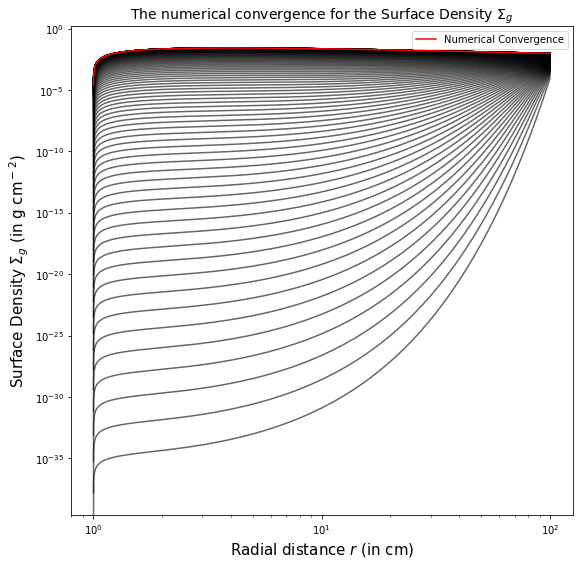

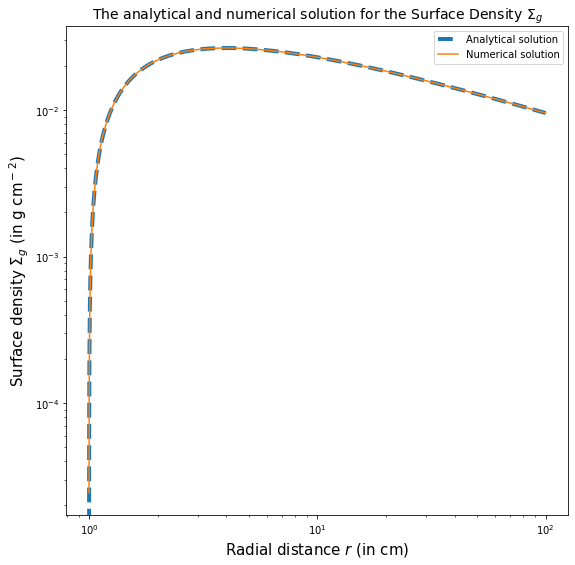

In [4]:
#create the disk with normalised units to easily compare it to the analytical solution
d = DiskRadialModel(rout=100, rin = 1, alpha=0.5, nr = 10000)

#we compute and normalise the kinematic viscosity
d.compute_nu()
d.nu = d.nu/d.nu[1]

#for the more 'dramatic' fill-up effect, sigma has been set to 0 everywhere at t=0
d.sigma = np.array([0] * 10000)

ntime = 100
tstart = 1     
tend = 10000
time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

plt.figure(figsize = (9,9))
plt.xscale('log')
plt.yscale('log')

#for each timestep we calculate the surface density as a function of r, for innerbc sigma and mdot_outer
for itime in range(1, ntime + 1):
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], alphamodel = False, 
        sigma_innerbc = d.sigma[1]/2., mdot_outerbc = 1)
    plt.plot(d.r, d.sigma, c='k', alpha = 0.6)
    
plt.plot(d.r, d.sigma, label='Numerical Convergence', c='r')
plt.xlabel(r'Radial distance $r$ (in cm)', fontsize = 15)
plt.ylabel(r'Surface Density $\Sigma_g$ (in g cm$^-$$^2$)', fontsize = 15)
plt.title(r'The numerical convergence for the Surface Density $\Sigma_g$', fontsize = 14)
plt.legend()
plt.show()

plt.figure(figsize = (9,9))
plt.xscale('log')
plt.yscale('log')
plt.plot(d.r, analytical_sigma(d.nu,1,1, d.r), label ='Analytical solution', linestyle ='dashed', linewidth=4)
plt.plot(d.r, d.sigma, label='Numerical solution')
plt.xlabel(r'Radial distance $r$ (in cm)', fontsize = 15)
plt.ylabel(r'Surface density $\Sigma_g$ (in g cm$^-$$^2$)', fontsize = 15)
plt.legend()
plt.title(r'The analytical and numerical solution for the Surface Density $\Sigma_g$', fontsize = 14)
plt.show()

Plotted above are two plots showing the distribution of the surface density as a function of the radial distance. Plotted in the top figure is the numerical convergence together with the surface density for different time steps. Visible is that the surface density increases as time progresses, until it has converged at the final red line.

Plotted in the bottom plot is the converged numerical distribution of the surface density as a function of the radial distance together with the analytical solution. Plotted as an orange line is the numerical solution, plotted as a dashed blue line is the analytical FRK solution.

As visible in this bottom plot, the numerical solution seems to perfectly follow the analytical solution from Frank Rayne and King. The units do not make much sense in this plot, since we have used natural units to show the fact that they are identical. 

To quantitatively show that this numerically calculated stationary state is identical to the analytical one, we can look at the fractional difference between both methods. This is plotted in the figure below:

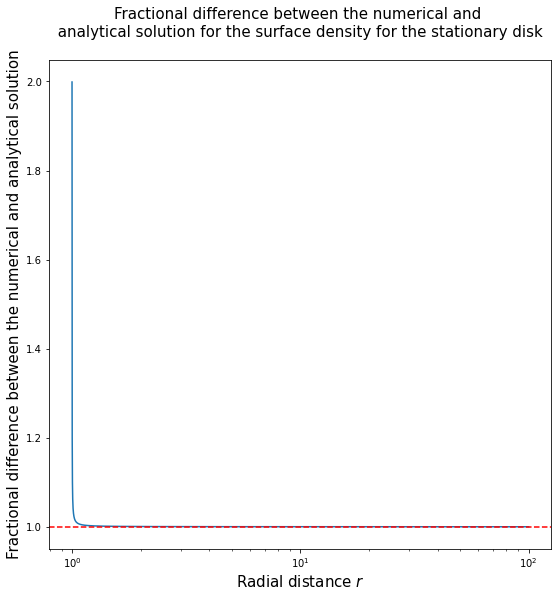

In [5]:
plt.figure(figsize = (9,9))
plt.plot(d.r, d.sigma/analytical_sigma(d.nu,1,1, d.r))
plt.title('Fractional difference between the numerical and \n analytical solution for the surface density for the stationary disk \n', fontsize = 15)
plt.ylabel('Fractional difference between the numerical and analytical solution', fontsize = 15)
plt.xlabel(r'Radial distance $r$', fontsize = 15)
plt.yscale('linear')
plt.axhline(y=1, c='r', linestyle = 'dashed')
plt.xscale('log')
plt.show()

As visible in the plot above, only at the start, there is a large fractional difference, where the numerical calculations return twice the values of the analytical ones. But after a small radial step, this incredibly quickly converges to one, to show that the numerical solution and analytical solution are identical.

To quantitatively show that the final stationary state has actually converged, one could sum the absolute differences between the distribution of the surface density for two consecutive time steps. If the total absolute differences would be lower than a certain pre-set value, for instance 1e-6, a conclusion could be drawn that the solution has converged!

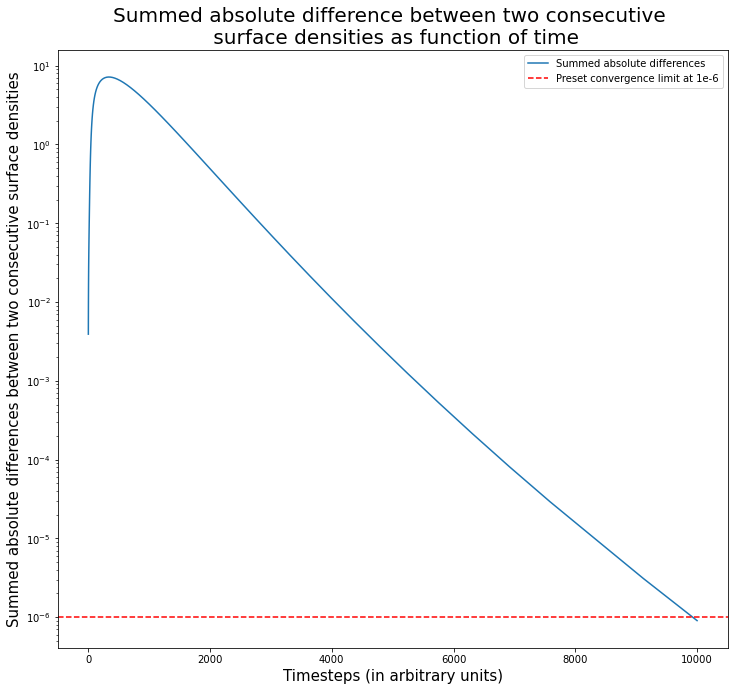

In [6]:
#create the disk with normalised units to easily compare it to the analytical solution
d = DiskRadialModel(rout=100, rin = 1, alpha=0.5, nr = 10000)

#we compute and normalise the kinematic viscosity
d.compute_nu()
d.nu = d.nu/d.nu[1]

#for the more 'dramatic' fill-up effect, sigma has been set to 0 everywhere at t=0
d.sigma = np.array([0] * 10000)

ntime = 100
tstart = 1     
tend = 10000
time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))
#for each timestep we calculate the surface density as a function of r, for innerbc sigma and mdot_outer

convergence_list = []
for itime in range(1, ntime + 1):
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], alphamodel = False, 
        sigma_innerbc = d.sigma[1]/2., mdot_outerbc = 1)

    if itime>1:
        convergence_list.append(sum(np.abs(old_sigma - d.sigma)))
    
    old_sigma = d.sigma
    
plt.figure(figsize = (12,11))
plt.plot(time[2:], convergence_list, label='Summed absolute differences')
plt.yscale('log')
plt.xscale('linear')
plt.axhline(y=1e-6, c='r', ls='dashed', label= 'Preset convergence limit at 1e-6')
plt.xlabel('Timesteps (in arbitrary units)', fontsize = 15)
plt.ylabel('Summed absolute differences between two consecutive surface densities', fontsize = 15)
plt.title('Summed absolute difference between two consecutive \n surface densities as function of time', fontsize = 20)
plt.legend()
plt.show()

Visible in this figure is that the summed absolute differences between two timesteps are initially quite small, quickly grow larger as the material is being put into the disk and the surface density increases by a lot. When it has hit its maximum, and the surface density starts to converge around the final spot, one can see that then the difference quickly goes down. It hits the pre-set value of 1e-6, after which we can quantitively conclude that it has converged!

### Viscous heating and realistic opacities

Now we want to add more physics into the problem, so ignoring everything about irradiation and flaring, we will now be looking at viscous heating. We stick to gas pressure dominated disks, and we choose realistic values for accretion rate, the mass of the central object and grid. In addition to solving the third equation, mentioned above, we are now also solving for heating and cooling of the disk, from which the mid-plane temperature can be calculated. To do this, we have to implement new opacity prescriptions into `disklab`, since it does not have the relevant one for accretion disks around compact objects. 

Hence a new opacity prescription has been implemented; kramer's free-free opacity: 

$$\kappa_{ff} = 3.68 \times 10^{22} g_{ff} (1-Z)(1+X) \rho_{g} T^{-7/2} \text{cm}^2 \text{g}^{-1}$$ 

where X and Z are hydrogen and metal abundances set at 0.7 and 0.02, and $g_{ff}$ is set to 1. We also set the Planck opacities to be identical to the Rosseland mean opacity.  

With this new opacity, we can calculate the mid-plane temperature for each timestep, with which we can calculate the scale height. From the scale height, we can update our mid-plane densities, and also our mean opacities for the next timestep! 

For physical parameters, we take a 10$M_{\odot}$ black hole, the inner disk to be at 6$r_g$, the outer disk to be at 600$r_g$, alpha to be 0.5, and Mdot to be 1% $\dot{M}_{\text{edd}}$. $\dot{M}_{\text{edd}}$ has been calculated by using the approximation that for a 10^8 solar mass black hole, the Eddington accretion rate is 2 solar masses per year. Again our initial surface density condition is that $\Sigma$ = 0 everywhere at t=0.

The result for the disk parameters ($\Sigma, T_c, \rho, \nu, H/R$) can then be compared to the analytical solutions in FRK eq 5.49. To do this, a universal fitting function with 6 free parameters (a constant and each power-law index) will be fitted to the numerical solutions, to try and obtain the same results as the analytical model: $$y = \text{a} \cdot \alpha^{\text{b}} \cdot \dot{M_{16}}^{\text{c}} \cdot m_1^{\text{d}} \cdot R_{10}^{\text{e}} \cdot f^{\text{f}},$$ where $\dot{M_{16}}$ has been normalised by a factor of $1e16$, and $R_{10}$ has been normalised by a factor of $1e10$.

100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


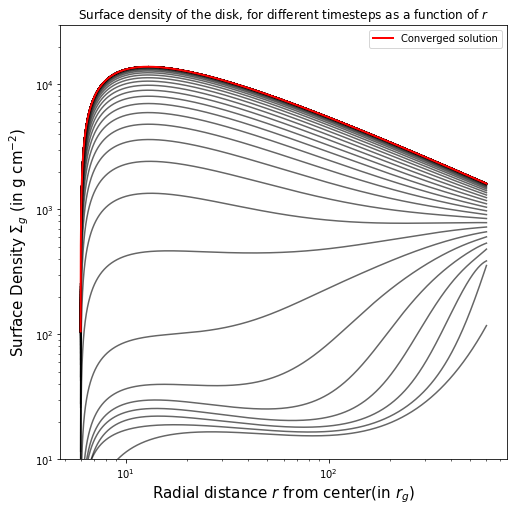

In [7]:
#we create our disk again, using physical units
d = DiskRadialModel(mstar = 10*MS, rout=600*rg(10*MS), rin = 6*rg(10*MS), alpha=0.5, nr = 10000)
#for the more 'dramatic' fill-up effect, sigma has been set to practically 0 everywhere at t=0
d.sigma = np.array([1] * 10000) * 1e-20

d.meanopacitymodel = ['kramer']
d.compute_mean_opacity()

ntime = 100
tstart = 10000
tend   = 10*year
time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

plt.figure(figsize = (8,8))

#the accretion rate is 1% of the eddington accretion rate
mdot = 1e-10 * 2 * 10 * MS /(year)

#for each timestep we update the disk
for itime in tqdm(range(1, ntime + 1)):
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], sigma_innerbc = d.sigma[1]/2., mdot_outerbc = mdot)
    
    #update the temperature, scale-height, soundspeed, midplane density and opacity 
    d.compute_disktmid(vischeat=True,simple=True)
    d.compute_cs_and_hp()
    d.compute_rhomid_from_sigma()
    d.compute_mean_opacity()
    
    plt.plot(d.r/rg(10*MS), d.sigma, alpha= 0.6, c='k') 

plt.plot(d.r/rg(10*MS), d.sigma, label='Converged solution', c='r', linewidth = 2)
plt.title(r'Surface density of the disk, for different timesteps as a function of $r$')
plt.xlabel(r'Radial distance $r$ from center(in $r_g$)', fontsize = 15)
plt.ylabel(r'Surface Density $\Sigma_g$ (in g cm$^{-2}$)', fontsize = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(1e1,3e4)
plt.show()

Visible in the figure above is the distribution of the surface density of the disk as a function of the radial distance. The grey lines are the surface density distributions for different timesteps increasing in density with time, the red line is the final converged solution. The disk is slowly filling up with material, hence the surface density slowly increases until convergence. At really low r the surface density quickly falls again, as we are reaching our zero-torque boundary condition. The surface density distributions that have not yet converged, initially have a wave-like shape, which is probably because by adding the opacity, we can now calculate the mid-plane density for the entire disk. This midplane density will add all sorts of extra physics to the disk, which is why the density seems to go up at the final inner stages of the disk before going down again. 

Our goal is to try to compare our numerical solutions for the disk parameters to the analytical expressions from FRK eq 5.49:

$$\Sigma = 5.2 \cdot \alpha^{-4/5} \cdot \dot{M_{16}}^{7/10} \cdot m_1^{1/4} \cdot R_{10}^{-3/4} \cdot f^{14/5}$$

$$T_c = 1.4\times 10^4 \cdot \alpha^{-1/5} \cdot \dot{M_{16}}^{3/10} \cdot m_1^{1/4} \cdot R_{10}^{-3/4} \cdot f^{6/5}$$

$$\rho = 3.1\times 10^{-8} \cdot \alpha^{-7/10} \cdot \dot{M_{16}}^{11/20} \cdot m_1^{5/8} \cdot R_{10}^{-15/8} \cdot f^{11/5}$$

$$\nu = 1.8 \times 10^{14} \cdot \alpha^{4/5} \cdot \dot{M_{16}}^{3/10} \cdot m_1^{-1/4} \cdot R_{10}^{3/4} \cdot f^{6/5}$$

$$H = 1.7 \times 10^{8} \cdot \alpha^{-1/10} \cdot \dot{M_{16}}^{3/20} \cdot m_1^{-3/8} \cdot R_{10}^{9/8} \cdot f^{3/5}$$

Lets plot all the numerical disk quantities, and their respective analytical solutions:

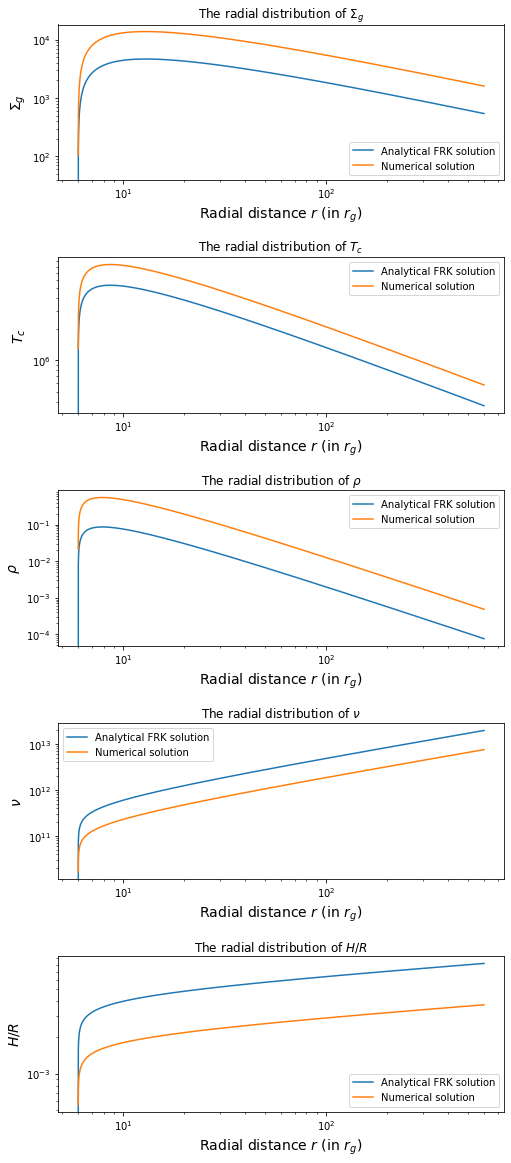

In [8]:
#the set of constants that correspond with the disk
set_constants = [0.5, (1e-10 * 2 * 10 * MS /(year))/(10**16), 10, d.r/(10**10), (1-((6*rg(10*MS))/d.r)**0.5)**0.25]

frk_sigma = FRK_sigma(*set_constants)
frk_Tc = FRK_Tc(*set_constants)
frk_rho = FRK_rho(*set_constants)
frk_nu = FRK_nu(*set_constants)
#because r has been normalised over 10^10, we need to devide by that factor here
frk_h_div_r = FRK_H_div_R(*set_constants)/10**10

var_frk_list = [frk_sigma, frk_Tc, frk_rho, frk_nu, frk_h_div_r]
var_num_list = [d.sigma, d.tmid, d.rhomid, d.nu, d.hp/(d.r)]
var_list = [r'$\Sigma_g$',r'$T_c$',r'$\rho$',r'$\nu$',r'$H/R$']

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,20))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.plot(d.r/rg(10*MS), var_frk_list[i], label='Analytical FRK solution')
    ax.plot(d.r/rg(10*MS), var_num_list[i], label='Numerical solution')
    ax.set_xlabel(r'Radial distance $r$ (in $r_g$)', fontsize = 14)
    ax.set_ylabel(var_list[i], fontsize = 14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('The radial distribution of {}'.format(var_list[i]))
    ax.legend()
plt.show()

Plotted above are the radial distributions for the realistic disks with Kramers opacity for the 5 different quantities ($\Sigma, T_c, \rho, \nu, H/R$). Plotted with orange lines are the numerical solutions, whereas the analytical FRK solutions have been plotted as blue lines. 

Visible is that $\textit{each}$ numerical solution follows the same shape and seems to have the same slope as the analytical solution, only offset by a certain factor. This makes sense, as the opacity used in Frank, Rayne and King are slightly different from the Kramer opacity used in the numerical simulations. 

To verify the power-law scalings of the variables and to find the coefficient that goes in front of the perfect solution, we can fit a universal function $y = \text{a} \cdot \alpha^{\text{b}} \cdot \dot{M_{16}}^{\text{c}} \cdot m_1^{\text{d}} \cdot R_{10}^{\text{e}} \cdot f^{\text{f}}$ to each numerical solution, so that we obtain the power-law scaling for each variable. We can then compare this again to the analytical case and thus verify that the numerical solution gives the same result as the analytically derived ones!

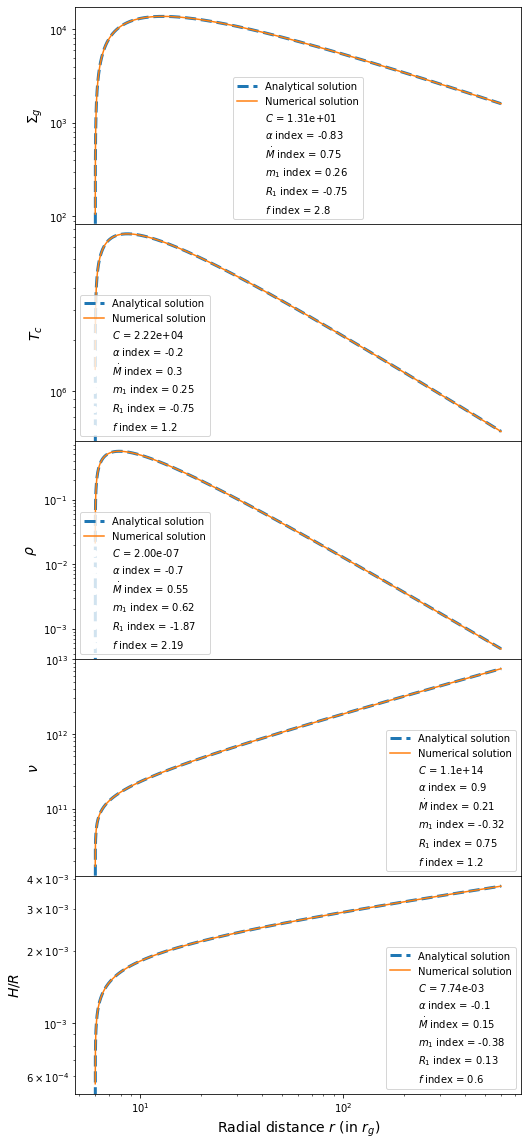

In [9]:
#the initial guesses for the fit function are set as the analytical parameters
parm_sigma = [5.2, -4/5, 7/10, 1/4, -3/4, 14/5]
parm_tc = [1.4*10**4, -1/5, 3/10, 1/4, -3/4, 6/5]
parm_rho = [3.1*10**(-8), -7/10, 11/20, 5/8, -15/8, 11/5]
parm_nu = [1.8*10**(14), 4/5, 3/10, -1/4, 3/4, 6/5]
parm_H = [1.7*10**(8), -1/10, 3/20, -3/8, 1/8, 3/5]

#we put loose bounds around the parameters, so that dimensionality is reduced
bound_sigma = ([-np.inf,-1, 0.5, 0.2, -1, 1.5],[np.inf,-0.6, 1,0.3,-0.5,3.5])
bound_tc = ([-np.inf,-0.5, 0.1, 0.1, -1, 1],[np.inf,-0.1, 0.5, 0.3,-0.5,2])
bound_rho = ([-np.inf,-1, 0.25, 0.3, -2.5, 1],[np.inf,-0.5, 0.75,0.8,-1,3.5])
bound_nu = ([10**13,0.5, 0.1, -0.4, 0.5, 0.8],[np.inf,1, 0.5,-0.1,1,2])
bound_H = ([-np.inf,-0.5, 0.01, -0.6, 0.01, 0.01],[np.inf, -0.05, 0.2,-0.1,0.5,0.8])

parmlist= np.array([parm_sigma, parm_tc, parm_rho, parm_nu, parm_H])

#we fit the universal function to each numerical solution
ml_parm_sigma, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.sigma, parm_sigma, bounds = bound_sigma)
ml_parm_tc, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.tmid, parm_tc, bounds = bound_tc)
ml_parm_rho, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.rhomid, parm_rho, bounds = bound_rho)
ml_parm_nu, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.nu, parm_nu, bounds = bound_nu) 
ml_parm_H, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.hp/(d.r), parm_H, bounds = bound_H)

ml_parmlist = np.array([ml_parm_sigma, ml_parm_tc, ml_parm_rho, ml_parm_nu, ml_parm_H])

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,20), sharex=True)
fig.subplots_adjust(hspace=0)
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.plot(d.r/rg(10*MS), FRK_fit(d.r, *ml_parmlist[i]), label='Analytical solution', linestyle='dashed', linewidth=3)
    ax.plot(d.r/rg(10*MS), var_num_list[i], label='Numerical solution')
    ax.set_xlabel(r'Radial distance $r$ (in $r_g$)', fontsize = 14)
    ax.set_ylabel(var_list[i], fontsize = 14)
    ax.scatter(0,0, c = 'white', label=r'$C$ = {}'.format(np.format_float_scientific(ml_parmlist[i][0], precision=2)))
    ax.scatter(0,0, c = 'white', label=r'$\alpha$ index = {}'.format(np.round(ml_parmlist[i][1],2)))
    ax.scatter(0,0, c = 'white', label=r'$\dot M$ index = {}'.format(np.round(ml_parmlist[i][2],2)))
    ax.scatter(0,0, c = 'white', label=r'$m_1$ index = {}'.format(np.round(ml_parmlist[i][3],2)))
    ax.scatter(0,0, c = 'white', label=r'$R_1$ index = {}'.format(np.round(ml_parmlist[i][4],2)))
    ax.scatter(0,0, c = 'white', label=r'$f$ index = {}'.format(np.round(ml_parmlist[i][5],2)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
plt.show()


Visible above is the universal function fitted to five different disk parameters as a function of r. We will discuss each disk parameter, and compare their power-law scalings starting with the surface density.

The surface density has been plotted in the first figure and the universal fitting function has been fitted to it. The results are in the table:

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |   13.14| -0.83| 0.75| 0.26| -0.75| 2.80|
| Analytical Solution |   5.20| -0.80| 0.70| 0.25| -0.75| 2.80|

Looking at the difference between the two, we can see that the analytical solution and the numerical fitted solution have the same power-law scalings, except for the constant in front of the function! This was expected as the opacity used in FRK is somewhat different, but the rest of the power-law scalings are almost identical! The numerical solution for the surface density is the same as the analytical one!

The mid-plane temperature has been plotted and the universal fitting function has been fitted to it. 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |   2.22e4| -0.20| 0.30| 0.25| -0.75| 1.20|
| Analytical Solution |  1.4e4| -0.20| 0.30| 0.25| -0.75| 1.20|

Looking at the difference between the two, we can see that the analytical solution and the numerical fitted solution have the same power-law scalings, again except for the constant in front of the function! The numerical solution for the mid-plane temperature is the same as the analytical one!

For the mid-plane density, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |   2.00e-7| -0.70| 0.55| 0.62| -1.87| 2.19|
| Analytical Solution |  3.10e-8| -0.70| 0.55| 0.63| -1.88| 2.20|

Looking at the difference between the two, we can see that the analytical solution and the numerical fitted solution have the same power-law scalings, again except for the constant in front of the function! The numerical solution for the mid-plane density is the same as the analytical one!

For the kinematic viscosity, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |  1.10e14| 0.90| 0.21| -0.32| 0.75| 1.20|
| Analytical Solution | 1.80e14| 0.80| 0.30| -0.25| 0.75| 1.20|

Looking at the difference between the two, we can see that for the kinematic viscosity the fit is not as good as the previous disk parameters. We can see that the power-law scalings for $R_{10}$ and $f$ are identical, but the power-law scalings for $\alpha, \dot{M_{16}}, \text{and}\ m_1$ are a small bit off. This fitting function is highly multi-dimensional, so we are likely in a local minimum for the optimizing function and thus do not get identical results. Nevertheless, the results are very close to each other!

For the H/R parameter, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |  7.74e-3| -0.1| 0.15| -0.38| 0.13| 0.60|
| Analytical Solution | 1.70e-2| -0.10| 0.15| -0.38| 0.13| 0.60|

Looking at the difference between the two, we can see that the analytical solution and the numerical fitted solution have the $\textit{exact}$ same power-law scalings, again except for the constant in front of the function! The numerical solution for the H/R parameter is the same as the analytical one!

The power-law scalings of the variables are in correspondence with the analytical power-law scalings from Frank, Rayne and King!

### Adding the Electron scattering opacity and the combined opacity

Now that we have confirmed that the numerical solution is the same as the analytical one, we can easily swap out the opacity laws and generate some new solutions!

We will generate new solutions via two new opacity laws. The first one is the electron scattering opacities given by:

$$\kappa_{es} = 0.2 (1+X),$$ 

where X again is the hydrogen abundance, which is 0.7 for this disk. The second opacity law that we will test is a simple addition of the electron scattering opacity + the kramer opacity law: 

$$\kappa_{\text{combined}} = \kappa_{\text{es}} + \kappa_{\text{ff}}$$

With these opacity laws, we can generate some new solutions!

100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


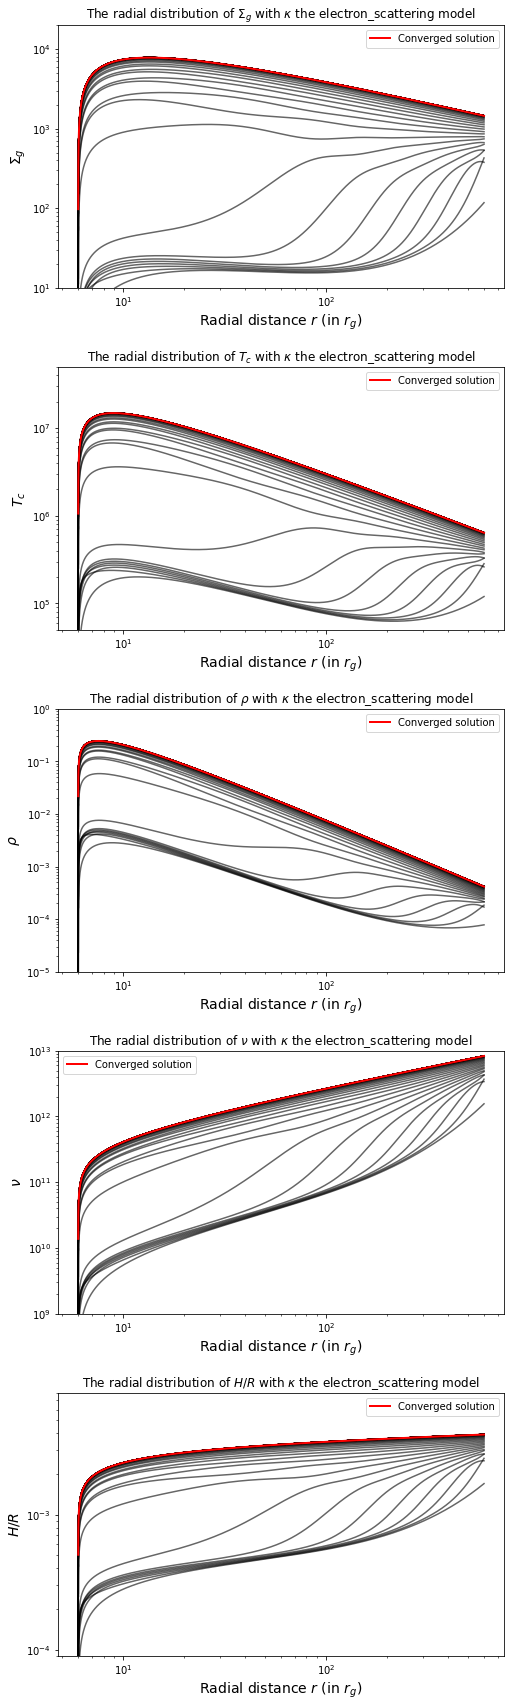

In [10]:
solution_for_opacity('electron_scattering', 10*MS, 600*rg(10*MS), 6*rg(10*MS), 0.5, 1e-10 * 2 * 10 * MS /(year))

Visible above are the new solutions to the realistic disks using the electron scattering opacity law. Plotted with a red line in each figure is the converged final solution, whereas the grey lines indicate the distribution as a step in time. Visible in these electron scattering opacity figures is that initially, the disk seems to converge at a lower value, as the black lines seem to 'clump' together at a lower value. This was not the case for the Kramer opacity, where the surface density kept increasing. Due to the continuous addition of mass, this 'local minimum' gets rejected as the convergence continues to the final converged solution. This 'local minimum' effect is seen through all the disk-parameters solutions, and I presume is thus due to the opacity and the 'non-dependence on temperature and density, together with the fact that we have not yet converged so the surface density is quite low at this point compared to the final solution. 

100%|██████████| 100/100 [00:02<00:00, 35.98it/s]


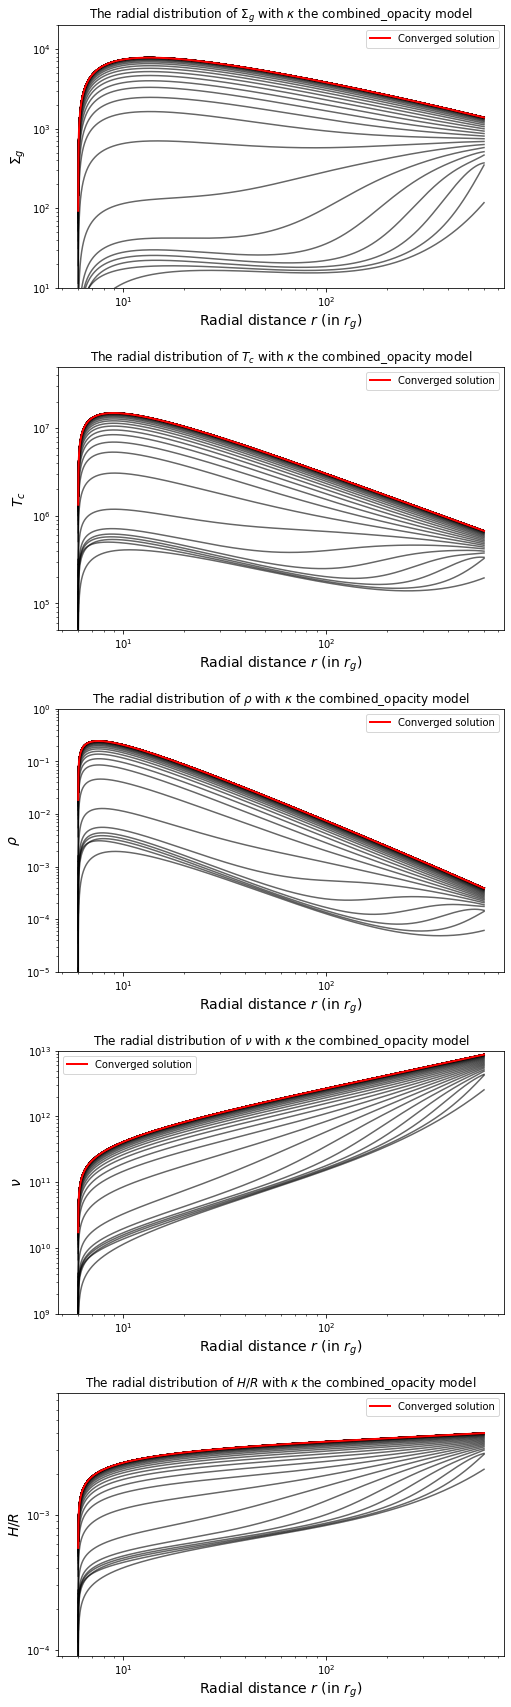

In [11]:
solution_for_opacity('combined_opacity', 10*MS, 600*rg(10*MS), 6*rg(10*MS), 0.5, 1e-10 * 2 * 10 * MS /(year))

Visible above are the new solutions to the realistic disks using the combined opacity model. Plotted with a red line in each figure is again the converged final solution, whereas the grey lines indicate the distribution as a step in time. Again visible in these disk-parameter solutions are the 'local minima' discussed above, however, with this combined model it seems that the solutions more quickly reject these local minima. These solutions spend less time 'stuck' in the local minimum and more quickly proceed to the final converged solution. The Kramer opacity did not have this intricacy, so this faster convergence speed is probably due to the addition of the Kramer opacity.

### Dominant opacity transition in the middle of the disk

With the combined opacity law, we can try to find a region in parameter space where the dominant opacity transitions from the electron scattering opacity to the Kramer opacity. With this region, we can then check what influence this has on the disk-parameter solutions by plotting several quantities and comparing them to the analytical free-free case. This can be done by again fitting the analytical universal function discussed above to these cases. By comparing power-law scalings, we can see what influence this region of parameter space has!

100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


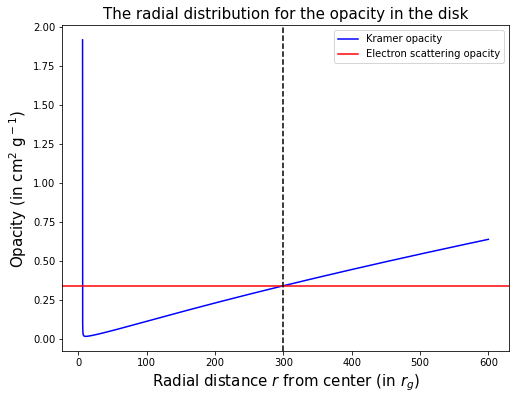

In [12]:
mass_star= 10 * MS

#we create our disk again, using physical units
d = DiskRadialModel(mstar = mass_star, rout=600*rg(mass_star), rin = 6*rg(mass_star), alpha=0.5, nr = 10000)
#for the more 'dramatic' fill-up effect, sigma has been set to practically 0 everywhere at t=0
d.sigma = np.array([1] * 10000) * 1e-20
d.meanopacitymodel = ['combined_opacity']
d.compute_mean_opacity()

ntime = 100
tstart = 10000
tend   = 10*year
time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

#the specific accretion rate is here 0.0663% of the eddington accretion rate
mdot = 0.0663 * 1e-10 * 2 * 10 * MS /(year)

#for each timestep we update the parameters for the disk
for itime in tqdm(range(1, ntime + 1)):
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], sigma_innerbc = d.sigma[1]/2., mdot_outerbc = mdot)
    
    #update the temperature, scale-height, soundspeed, midplane density and opacity 
    d.compute_disktmid(vischeat=True,simple=True)
    d.compute_cs_and_hp()
    d.compute_rhomid_from_sigma()
    d.compute_mean_opacity()
    
kappa_electronscattering = (0.2*(1+0.7))
kappa_kramer = (3.68*10**22 * 1 * (1-0.02) * (1+0.7)* d.rhomid * d.tmid**(-7/2))

plt.figure(figsize = (8,6))
plt.plot(d.r/rg(10*MS), kappa_kramer, c='b', label='Kramer opacity')
plt.axhline(y=kappa_electronscattering, c='r', label='Electron scattering opacity')
plt.axvline(x=300, c='k', linestyle='dashed')
plt.xlabel(r'Radial distance $r$ from center (in $r_g$)', fontsize = 15)
plt.ylabel(r'Opacity (in cm$^2$ g$^-$$^1$)', fontsize = 15)
plt.title('The radial distribution for the opacity in the disk', fontsize = 15)
plt.legend()
plt.show()

Visible in the plot above is that for a $10 M_{\odot}$ black hole, with its inner-disk radius at 6 $r_g$, its outer-disk radius at 600 $r_g$, and an accretion rate of 0.0663% $\dot{M}_{\text{edd}}$, the dominant opacity transitions from the electron scattering opacity to the Kramer opacity exactly in the middle of the disk!

The question we want to answer then is: What influence does this have on the solutions? For this, the universal fitting function will again be fitted to the solutions, to see any discrepancies with the analytical free-free case. 

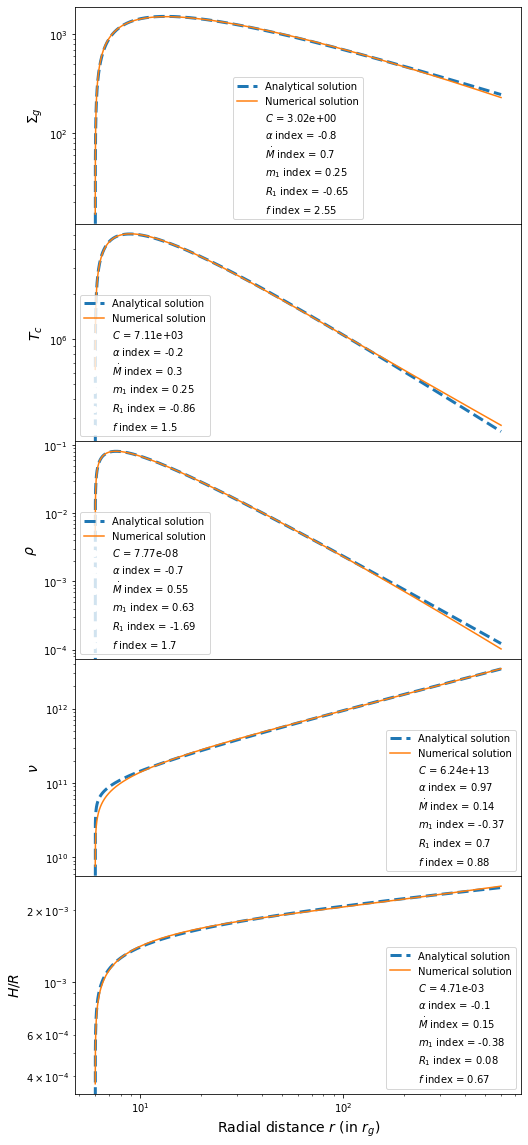

In [13]:
#the initial guesses for the fit function are set as the analytical parameters
parm_sigma = [5.2, -4/5, 7/10, 1/4, -3/4, 14/5]
parm_tc = [1.4*10**4, -1/5, 3/10, 1/4, -3/4, 6/5]
parm_rho = [3.1*10**(-8), -7/10, 11/20, 5/8, -15/8, 11/5]
parm_nu = [1.8*10**(14), 4/5, 3/10, -1/4, 3/4, 6/5]
parm_H = [1.7*10**(8), -1/10, 3/20, -3/8, 1/8, 3/5]

#we put loose bounds around the parameters, so that the dimensionality is reduced
bound_sigma = ([-np.inf,-1, 0.5, 0.2, -1, 1.5],[np.inf,-0.6, 1,0.3,-0.5,3.5])
bound_tc = ([-np.inf,-0.5, 0.1, 0.1, -1, 1],[np.inf,-0.1, 0.5, 0.3,-0.5,2])
bound_rho = ([-np.inf,-1, 0.25, 0.3, -2.5, 1],[np.inf,-0.5, 0.75,0.8,-1,3.5])
bound_nu = ([10**13,0.5, 0.1, -0.4, 0.5, 0.8],[np.inf,1, 0.5,-0.1,1,2])
bound_H = ([-np.inf,-0.5, 0.01, -0.6, 0.01, 0.01],[np.inf, -0.05, 0.2,-0.1,0.5,0.8])

parmlist= [parm_sigma, parm_tc, parm_rho, parm_nu, parm_H] 
var_num_list = [d.sigma, d.tmid, d.rhomid, d.nu, d.hp/(d.r)]

#we fit the universal function to each numerical solution
ml_parm_sigma, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.sigma, parm_sigma, bounds = bound_sigma) 
ml_parm_tc, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.tmid, parm_tc, bounds = bound_tc)
ml_parm_rho, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.rhomid, parm_rho, bounds = bound_rho)
ml_parm_nu, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.nu, parm_nu, bounds = bound_nu) 
ml_parm_H, ml_cfcovar = spopt.curve_fit(FRK_fit, d.r, d.hp/(d.r), parm_H, bounds = bound_H)

ml_parmlist = [ml_parm_sigma, ml_parm_tc, ml_parm_rho, ml_parm_nu, ml_parm_H]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,20), sharex=True)
fig.subplots_adjust(hspace=0)
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.plot(d.r/rg(10*MS), FRK_fit(d.r, *ml_parmlist[i]), label='Analytical solution', linestyle='dashed', linewidth=3)
    ax.plot(d.r/rg(10*MS), var_num_list[i], label='Numerical solution')
    ax.set_xlabel(r'Radial distance $r$ (in $r_g$)', fontsize = 14)
    ax.set_ylabel(var_list[i], fontsize = 14)
    ax.scatter(0,0, c = 'white', label=r'$C$ = {}'.format(np.format_float_scientific(ml_parmlist[i][0], precision=2)))
    ax.scatter(0,0, c = 'white', label=r'$\alpha$ index = {}'.format(np.round(ml_parmlist[i][1],2)))
    ax.scatter(0,0, c = 'white', label=r'$\dot M$ index = {}'.format(np.round(ml_parmlist[i][2],2)))
    ax.scatter(0,0, c = 'white', label=r'$m_1$ index = {}'.format(np.round(ml_parmlist[i][3],2)))
    ax.scatter(0,0, c = 'white', label=r'$R_1$ index = {}'.format(np.round(ml_parmlist[i][4],2)))
    ax.scatter(0,0, c = 'white', label=r'$f$ index = {}'.format(np.round(ml_parmlist[i][5],2)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
plt.show()

Visible in the plots above are the numerical solutions for the combined opacity, which switches dominancy in the exact middle of the disk from the electron scattering opacity to the kramers opacity, fitted with the analytical solutions for the kramer opacity case. For the surface density, the midplane temperature and the mid-plane density, the analytical solution seems to deviate from the numerical at large r. For the H/R parameter and the kinematic viscosity, the analytical solution seem to deviate from the solution at small r.

Lets investigate the specific power-law scalings and compare them to the analytical ones:

The surface density has again been plotted in the first figure and the universal fitting function has been fitted to it. The results are in the table below:

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |    3.02| -0.8|  0.7|  0.25| -0.65| 2.55|
| Analytical Solution |   5.20| -0.80| 0.70| 0.25| -0.75| 2.80|

We can see that even though the power-law scalings for $\alpha$, $\dot{M_{16}}$, and $m_1$ are identical to the free-free solutions, the $R_{10}$, and $f$ power-law scalings are not quite identical. This difference in power-law scalings is also visible from the fit function, as the numerical solution begins to deviate from the analytical one near the edge of the outer disk. 

The mid-plane temperature has been plotted and the universal fitting function has been fitted to it. 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |  7.11e3| -0.20|0.3| 0.25| -0.86| 1.50|
| Analytical Solution |  1.4e4| -0.20| 0.30| 0.25| -0.75| 1.20|

We can see again that even though the power-law scalings for $\alpha$, $\dot{M_{16}}$, and $m_1$ are identical to the free-free solutions, the $R_{10}$, and $f$ power-law scalings are not quite identical. This difference in power-law scalings is also again visible from the fit function, as the numerical solution begins to deviate from the analytical one near the edge of the outer disk. 

For the mid-plane density, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution |   7.77e-8|   -0.70|   0.55|  0.63| -1.69|  1.7 |
| Analytical Solution |  3.10e-8| -0.70| 0.55| 0.63| -1.88| 2.20|

We can see yet again that even though the power-law scalings for $\alpha$, $\dot{M_{16}}$, and $m_1$ are identical to the free-free solutions, the $R_{10}$, and $f$ power-law scalings are not quite identical. This difference in power-law scalings is also yet again visible from the fit function, as the numerical solution begins to deviate from the analytical one near the edge of the outer disk. 

For the kinematic viscosity, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution | 6.24e+13|  0.97 | 0.14| -0.37| 0.70|  0.88|
| Analytical Solution | 1.80e14| 0.80| 0.30| -0.25| 0.75| 1.20|

Looking at the differences between the solutions, we can see that the free-free opacity case is not a good fit for the viscosity, as none of the parameters overlaps. This is also visible from the plot itself, as the numerical and the analytical models deviate quite quickly from each other at the inner radius. Maybe because of the high dimensionality, it converged to another minimum, but as it stands, this is not a good fit. 

For the H/R parameter, the results are: 

|          | Constant | $\alpha$ | Ṁ$_1$$_6$ | $m_1$ | $R_1$$_0$ | $f$ |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Numerical Solution | 4.71e-3 | -0.1 | 0.15| -0.38| 0.08| 0.67|
| Analytical Solution | 1.70e-2| -0.10| 0.15| -0.38| 0.13| 0.60|

We can see that the power-law scalings for $\alpha$, $\dot{M_{16}}$, and $m_1$ are identical to the free-free solutions, and that even the $R_{10}$, and $f$ power-law scalings are reasonably accurate to the analytical case. From the plot itself it is visible that the fit is decent!

Due to the gradual change of the opacity domain, there is also a gradual change of the power-law scalings coefficients. The reason why $R_{10}$ changes most of the time is presumably that we are plotting our results against the radial dependence $r$, which makes it the most impactful to change!

# CS2

In Computing Set 2, we want to create mock spectra of the disks from part 1 and see how they change upon varying the parameters. We assume a combined opacity like in part 1, and we assume that the disk radiates locally as a blackbody. We use the same physical constants for the disk above, changing only the outer-disk radius to 1000 $r_g$ and the accretion rate to 5% $\dot{M}_{edd}$. 

The first thing we need to look at is the disk's surface temperature. The disks surface temperature can be calculated in three separate ways: 

- In a stationary state and zero-torque at the inner radius, we have shown that $$\sigma_{SB} T_S^4 = \frac{3 G M \dot{M}}{8 \pi R^3} \Biggl(1-\Biggl( \frac{R_*}{R}\Biggr)^{1/2}\Biggr),$$ from which we can easily calculate the surface temperature
<br>

- The second method it by using the viscous dissipation rate tracked by disklab in the variable d.qvisc, from which we can also calculate the temperature like so: $$\sigma_{SB} T_S^4 = \frac{\texttt{d.qvisc}}{2}$$
<br>
- The third method is by using the 'Eddington Approximation' we had seen in class together with the midplane-temperature calculated by disklab: $$T_S^4 = \frac{4 T_c^4}{3 \tau}$$, where $\tau = \Sigma \cdot \kappa_{R}$.

Lets compare the radial distributions for these three calculated temperatures in the disk: 

In [14]:
def temperature_statstate_zerotorque(r):
    """ calculates the temperature via the stationary state and zero-torque method 
    :param r: an value or array for the radial distance
    :return: the surface temperature
    """
    sigma = 5.670374*10**(-5)
    G = 6.674*10**(-8)
    M = 10* MS
    mdot = 0.05 * 1e-8 * 2 * 10 * MS /(year)
    return ((1/sigma)*((3 * G * M * mdot)/(8 * np.pi * r**3)) * (1-((6*rg(10*MS))/(r))**0.5))**0.25

def plancks_law(T, nu):
    """ spectral radiance according to Planks law for frequency nu and absolute temperature T
    :param T: absolute temperature
    :param nu: frequency array
    :return: the spectral radiance according to Planks law
    """
    h = 6.6261965*10**(-27)
    c = 2.99792458*10**(10)
    kb = 1.380649*10**(-16)
    return ((2 * h * nu**3)/(c**2)) * ((1)/(np.exp((h*nu)/(kb * T)) - 1))

def parameter_sweep(mdot, r_in, r_out, mass_star, alpha):   
    """ returns the total spectral energy distribution of the disk for different disk parameters
    :param mdot: the accretion rate of the system
    :param r_in: the inner-radius of the disk
    :param r_out: the outer-radius of the disk
    :param mass_star: the mass of the black hole
    :param alpha: the ignorance alpha parameter
    :return total_irradiance: the total spectral energy distribution
    :return frequency_array: the frequency array
    """
    #we create our disk again, using physical units
    d = DiskRadialModel(mstar = mass_star, rout=r_out*rg(mass_star), rin = r_in*rg(mass_star), alpha=0.5, nr = 10000)
    #for the more 'dramatic' fill-up effect, sigma has been set to practically 0 everywhere at t=0
    d.sigma = np.array([1] * 10000) * 1e-20

    d.meanopacitymodel = ['combined_opacity']
    d.compute_mean_opacity()

    ntime = 100
    tstart = 10000
    tend   = 100*year
    time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

    #for each timestep we update the parameters for the disk
    for itime in range(1, ntime + 1):
        d.sigma = d.get_viscous_evolution_next_timestep(
            time[itime] - time[itime - 1], sigma_innerbc = d.sigma[1]/2., mdot_outerbc = mdot)

        #update the temperature, scale-height, soundspeed, midplane density and opacity 
        d.compute_disktmid(vischeat=True,simple=True)
        d.compute_cs_and_hp()
        d.compute_rhomid_from_sigma()
        d.compute_mean_opacity()

    planck_array_list = []
    t_average_list = []
    frequency_array = np.logspace(12,19, 10000)
    total_irradiance = np.asarray([0]*10000)
    second_temp = (d.qvisc/(2 * 5.670374*10**(-5)))**0.25
    
    #sum the each single BB spectrum to a total spectrum for each dr piece-length
    for i in range(1, len(d.r)):
        largest = 0
        surface_area = (np.pi * d.r[i]**2) - (np.pi * d.r[i-1]**2) 
        delta_temp = (second_temp[i-1] + second_temp[i])/2
        t_average_list.append(delta_temp)
        total_irradiance = total_irradiance + (plancks_law(delta_temp, frequency_array) * surface_area)
    
    return total_irradiance, frequency_array

But first, we must again initialise the disk:

100%|██████████| 100/100 [00:02<00:00, 40.33it/s]


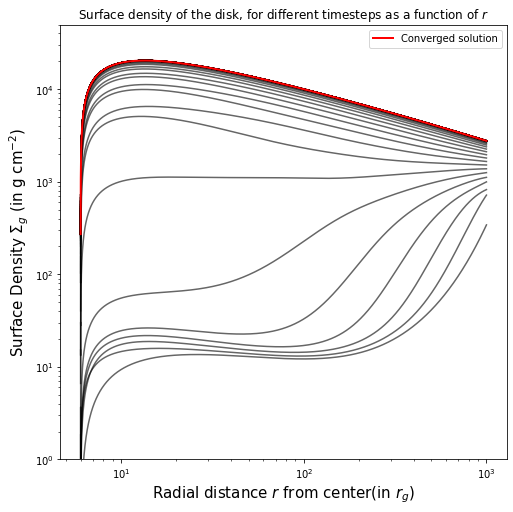

Initialisation Successful


In [15]:
mass_star= 10 * MS

#we create our disk again, using physical units
d = DiskRadialModel(mstar = mass_star, rout=1000*rg(mass_star), rin = 6*rg(mass_star), alpha=0.5, nr = 10000)
#for the more 'dramatic' fill-up effect, sigma has been set to practically 0 everywhere at t=0
d.sigma = np.array([1] * 10000) * 1e-20

d.meanopacitymodel = ['combined_opacity']
d.compute_mean_opacity()

ntime = 100
tstart = 10000
tend   = 100*year
time = tstart * (tend / tstart)**(np.linspace(0., 1., ntime + 1))

plt.figure(figsize = (8,8))

#we take 5% of the Eddington accretion rate
mdot = 0.05 * 1e-8 * 2 * 10 * MS /(year)

#for each timestep we update the parameters for the disk
for itime in tqdm(range(1, ntime + 1)):
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], sigma_innerbc = d.sigma[1]/2., mdot_outerbc = mdot)
    
    #update the temperature, scale-height, soundspeed, midplane density and opacity 
    d.compute_disktmid(vischeat=True,simple=True)
    d.compute_cs_and_hp()
    d.compute_rhomid_from_sigma()
    d.compute_mean_opacity()
    plt.plot(d.r/rg(10*MS), d.sigma, c='k', alpha = 0.6)

plt.plot(d.r/rg(10*MS), d.sigma, label='Converged solution', c='r', linewidth = 2)
plt.title(r'Surface density of the disk, for different timesteps as a function of $r$')
plt.xlabel(r'Radial distance $r$ from center(in $r_g$)', fontsize = 15)
plt.ylabel(r'Surface Density $\Sigma_g$ (in g cm$^{-2}$)', fontsize = 15)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(1e0, 0.5e5)
plt.show()

print('Initialisation Successful')

After the initialisation of the disk, we can now calculate the surface temperature via our three methods described above:

In [16]:
tau = d.sigma*d.mean_opacity_rosseland

first_temp = temperature_statstate_zerotorque(d.r)
second_temp = (d.qvisc/(2 * 5.670374*10**(-5)))**0.25
third_temp = (4 * d.tmid**4/(3 * tau))**0.25

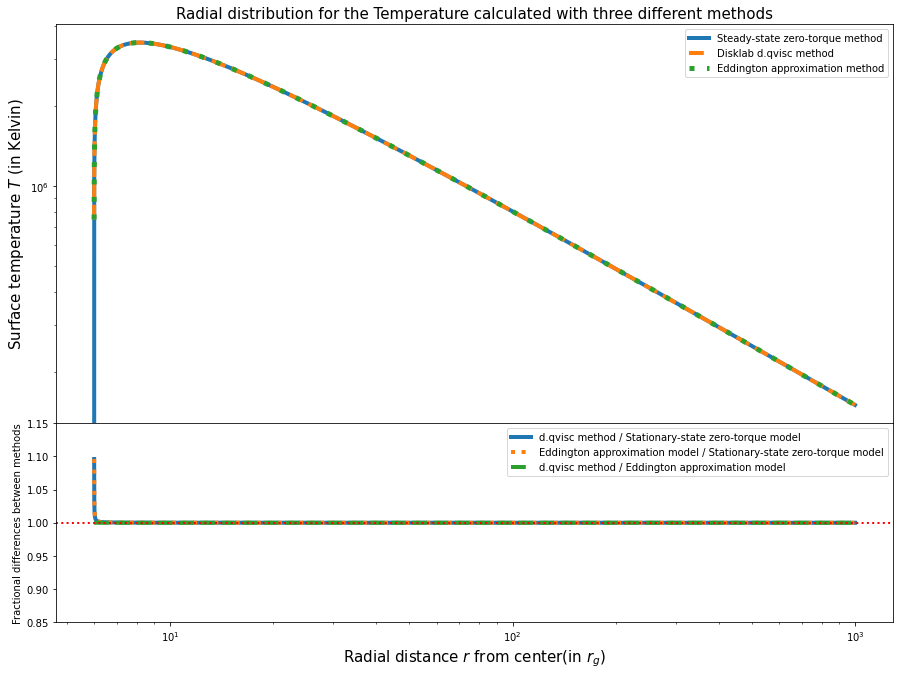

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,11),sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0)
ax1.plot(d.r/rg(10*MS), first_temp, linewidth = 4, label='Steady-state zero-torque method')
ax1.plot(d.r/rg(10*MS), second_temp, label=r'Disklab d.qvisc method', linewidth = 4, linestyle='dashed')
ax1.plot(d.r/rg(10*MS), third_temp, label='Eddington approximation method', linestyle=(0, (1, 2.5)), linewidth = 5)
ax2.plot(d.r/rg(10*MS), (second_temp/first_temp), linewidth = 4, label='d.qvisc method / Stationary-state zero-torque model')
ax2.plot(d.r/rg(10*MS), (third_temp/first_temp), linewidth = 4, ls='dotted', label='Eddington approximation model / Stationary-state zero-torque model')
ax2.plot(d.r/rg(10*MS), (second_temp/third_temp), linewidth = 4, ls='dashed', label='d.qvisc method / Eddington approximation model')
ax2.set_ylim(0.85,1.15)
ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) ## when showing residuals it is useful to also show the 0 line
ax2.set_ylabel('Fractional differences between methods')
ax1.set_ylabel('Surface temperature $T$ (in Kelvin)', fontsize = 15)
ax2.set_xlabel(r'Radial distance $r$ from center(in $r_g$)', fontsize = 15)
ax1.set_title('Radial distribution for the Temperature calculated with three different methods', fontsize = 15)
ax2.set_yscale('linear')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax2.legend()
plt.show()

As visible in the plot above, the three methods calculate the same surface temperature, except for at the very start, where there is a factor difference of about 1.1 between the stationary-state zero-torque method and the other two methods. This difference is not present when looking at the fractional difference between the d.qvisc method and the Eddington approximation method. It might have arisen because the stationary-state zero-torque model starts at a lower point, which would explain the fact that this fractional difference of 1.1 immediately disappears after increasing $r$ to be a step further than $r_{in}$. 

Nevertheless, the temperature calculations are in (pretty much) perfect correspondence with each other!

For the next parts, the d.qvisc method will be used. 

Since the disk emits as a blackbody, it emits with a Planck spectrum, with the single parameter, the temperature, calculated from the dissipation rate for that radius. By calculating
the spectrum for each radius, multiplying by the disk area contributing to that radius and summing
with the spectra for the other radii, one can calculate a total spectral energy distribution $\nu L_{\nu}(\nu)$. This spectrum can then be checked if it conforms to what we expect!

In [18]:
frequency_array = np.logspace(12,19, 10000)

planck_array_list = []
t_average_list = []
total_irradiance = np.asarray([0]*10000)

#per 1000 dr piece-lengths, plot one dr spectrum for it
for i in range(2000, len(d.r), 1000):
    surface_area = (np.pi * d.r[i]**2) - (np.pi * d.r[i-1000]**2) 
    delta_temp = (second_temp[i-1000] + second_temp[i])/2
    planck_array_list.append(plancks_law(delta_temp, frequency_array) * surface_area)
    
#sum the each single BB spectrum to a total spectrum for each dr piece-length
for i in range(1, len(d.r)):
    largest = 0
    surface_area = (np.pi * d.r[i]**2) - (np.pi * d.r[i-1]**2) 
    delta_temp = (second_temp[i-1] + second_temp[i])/2
    t_average_list.append(delta_temp)
    total_irradiance = total_irradiance + (plancks_law(delta_temp, frequency_array) * surface_area)

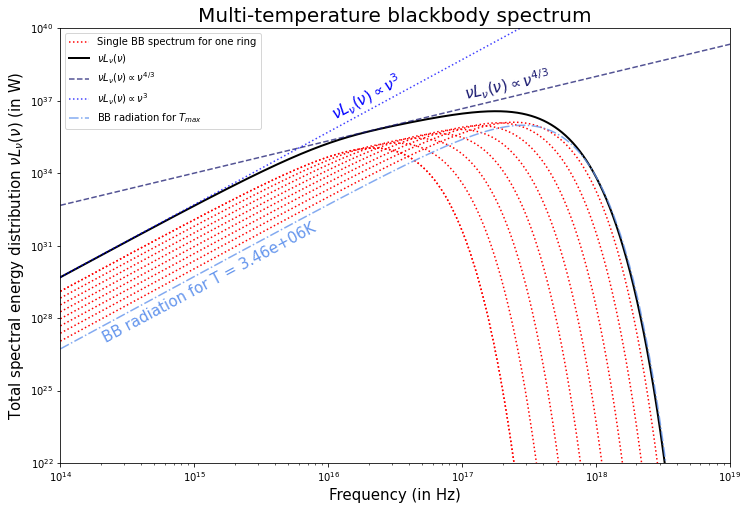

In [19]:
plt.figure(figsize = (12,8))

#plot the spectra for only one piece-length 
for i in range(len(planck_array_list)):
    plt.plot(frequency_array, planck_array_list[i]*frequency_array, linestyle='dotted', c = 'r')
    
plt.plot(frequency_array, planck_array_list[i]*frequency_array, linestyle='dotted', c = 'r', label='Single BB spectrum for one ring')
plt.plot(frequency_array, total_irradiance*frequency_array, c = 'k', label=r'$\nu L_{\nu}(\nu)$', lw = 2)
plt.plot(frequency_array, 1e14*frequency_array**(4/3), linestyle='dashed', c= 'midnightblue', alpha = 0.75, label =r'$\nu L_{\nu}(\nu) \propto \nu^{4/3}$')
plt.plot(frequency_array, 0.5e-12*frequency_array**(3), linestyle='dotted', c= 'b', alpha = 0.75, label=r'$\nu L_{\nu}(\nu) \propto \nu^{3}$')
plt.plot(frequency_array, 5e14*frequency_array*plancks_law(max(t_average_list), frequency_array), linestyle='dashdot', c= 'cornflowerblue', alpha = 0.8, label=r'BB radiation for $T_{max}$')
plt.text(1e17, 1e37, r'$\nu L_{\nu}(\nu) \propto \nu^{4/3}$', c='midnightblue', rotation=12.0, fontsize = 15)
plt.text(1e16, 1.5e36, r'$\nu L_{\nu}(\nu) \propto \nu^{3}$', c='b', rotation=28, fontsize = 15)
plt.text(2e14, 1e27, 'BB radiation for T = {}K'.format(np.format_float_scientific(max(t_average_list), precision=2)), c='cornflowerblue', rotation = 28, fontsize = 15)
plt.xlabel('Frequency (in Hz)', fontsize = 15)
plt.ylabel(r'Total spectral energy distribution $\nu L_{\nu}(\nu)$ (in W)', fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22, 1e40)
plt.xlim(1e14, 1e19)
plt.legend()
plt.title('Multi-temperature blackbody spectrum', fontsize = 20)
plt.show()

Visible in the plot above is the multi-temperature blackbody spectrum, where the area under the curve corresponds to the energy. Plotted in this figure is the total spectral energy distribution $\nu L_{\nu}(\nu)$ as a firm black line. The dotted red lines are single black body spectra corresponding to one ring in the disk. Furthermore, three blue lines are plotted in the graph, which is our theoretical prediction for the total spectral energy distribution curve.

The dotted blue line is the line that we predict the low-energy part of the spectrum to follow, as it corresponds to an energy corresponding to the lowest kT (largest radius) spectrum, dominated by the 'tail' of the single blackbody spectrum from that radius. This tail is approximated by the Rayleigh-Jeans approximation, hence this line is proportional to $\nu L_{\nu}(\nu) \propto \nu^{3}$. 

The dashed midnight-blue line is the line that we predict the slope of the peak of the spectrum to follow. It should have a more shallow slope than the previous line, as some of the single black body spectra already fall off at this point. The line is proportional to $\nu L_{\nu}(\nu) \propto \nu^{4/3}$. 

The final dash-dotted cornflower-blue line is the line corresponding to the blackbody radius of the innermost radii(highest temperature). It follows a single black body spectrum. The total irradiance spectrum is predicted to 'fall off' just as steeply because the final single black body spectrum accounts for almost all of the total spectral energy distribution at that point.

The total spectral energy distribution follows each blue line perfectly! The low- and high-frequency ends are exactly where we expected them to be!

### Parameter sweep for $\dot{M}, r_{\text{in}}, r_{\text{out}}, \text{and}\ M_{BH}$

After all the checks made above, we can be pretty sure that our spectrum corresponds with the theoretical spectrum we expect the disk to have. It is now then interesting to make four parameter sweeps. We are interested in how the spectrum will change by changing $\dot{M}, r_{\text{in}}, r_{\text{out}}, \text{and}\ M_{BH}$. 

#### Let's start with the parameter sweep for $\dot{M}$

In [20]:
irradiance_list_mdot = []
mdot_frac = np.logspace(-4, 0, 50)

#calculate the irradiance for 50 different accretion rates based upon the eddington accretion rate
for i in tqdm(range(0,50)):
    total_irradiance, frequency_array = parameter_sweep(mdot_frac[i] * 1e-8 * 2 * (10 * MS) /(year), 6, 1000, (10 * MS), 0.5)
    irradiance_list_mdot.append(total_irradiance)

100%|██████████| 50/50 [06:53<00:00,  8.26s/it]


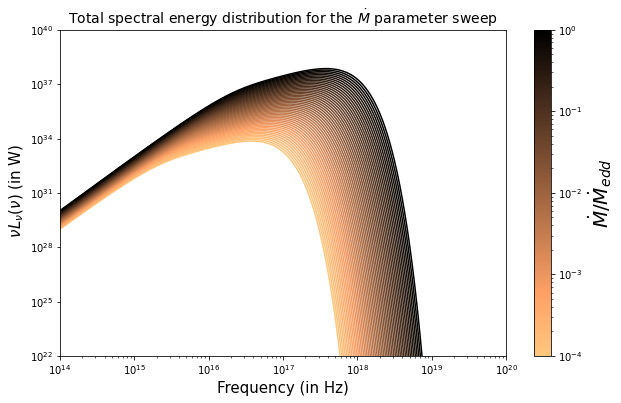

In [21]:
plt.figure(figsize = (10,6))
colours = plt.cm.copper_r(np.linspace(0,1,50))

#plot the total spectral energy distribution for each mdot
for i in range(0,50):
    plt.plot(frequency_array, irradiance_list_mdot[i]*frequency_array, c = colours[i], label=r'$\nu L$')

cmap = mpl.cm.copper_r
norm = mpl.colors.LogNorm(vmin=mdot_frac[0], vmax=mdot_frac[-1])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='vertical').set_label(label = r'$\dot{M}/\dot{M}_{edd}$', size = 20)

plt.xlabel('Frequency (in Hz)', fontsize = 15)
plt.ylabel(r' $\nu L_{\nu}(\nu)$ (in W)', fontsize = 15)
plt.title(r'Total spectral energy distribution for the $\dot{M}$ parameter sweep', fontsize = 14)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22, 1e40)
plt.xlim(1e14, 1e20)
plt.show()

Plotted in the plot above are the total spectral energy distributions for each different $\dot{M}$ in the $\dot{M}$ parameter sweep. The spectra which have been created with a lower accretion rate are plotted with a lighter colour, as in correspondence with the colour map on the side of the plot. In this parameter sweep, $\dot{M}$ has been changed from $0.0001\cdot \dot{M}_{edd}$ all the way to $1 \cdot \dot{M}_{edd}$ with 50 steps in between. 

Visible is that for increasing accretion rate, the peak of the spectrum shifts to higher frequencies and shifts to $\nu L_{\nu}(\nu)$. This makes sense, as by increasing the amount of matter being accreted into the system, we directly increase the temperature of the disk. By increasing the temperature of the disk, $\nu_{\text{peak}}$ will shift according to Wien's displacement law with the temperature, and will thus also increase for increasing temperatures. $\nu L_{\nu}(\nu)$ is related to the temperature by: $\nu L_\nu (\nu) \propto A T \nu^3$, and will thus also shift upwards!

#### Let's look at the parameter sweep for ${r_{in}}$

In [22]:
irradiance_list_rin = []
rin_frac = np.linspace(6, 60, 50)

#calculate the irradiance for 50 different inner-disk radii
for i in tqdm(range(0,50)):
    total_irradiance, frequency_array = parameter_sweep(0.05 * 1e-8 * 2 * (10 * MS) /(year), rin_frac[i], 1000, (10 * MS), 0.5)
    irradiance_list_rin.append(total_irradiance)

100%|██████████| 50/50 [06:27<00:00,  7.75s/it]


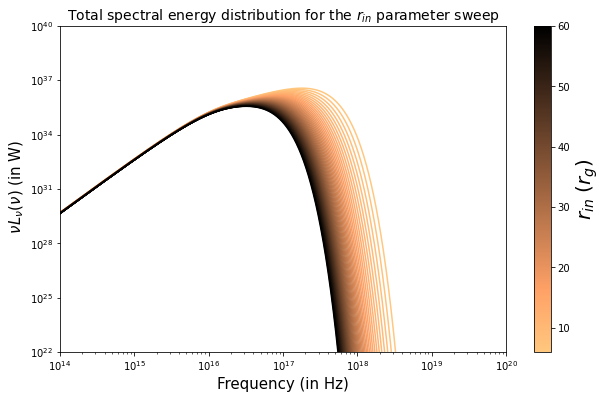

In [23]:
plt.figure(figsize = (10,6))
colours = plt.cm.copper_r(np.linspace(0,1,50))

#plot the total spectral energy distribution for each different radii
for i in range(0,50):
    plt.plot(frequency_array, irradiance_list_rin[i]*frequency_array, c = colours[i], label=r'$\nu L$')

cmap = mpl.cm.copper_r
norm = mpl.colors.Normalize(vmin=rin_frac[0], vmax=rin_frac[-1])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='vertical').set_label(label = r'$r_{in}$ ($r_{g})$', size = 20)

plt.xlabel('Frequency (in Hz)', fontsize = 15)
plt.ylabel(r' $\nu L_{\nu}(\nu)$ (in W)', fontsize = 15)
plt.title(r'Total spectral energy distribution for the $r_{in}$ parameter sweep', fontsize = 14)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22, 1e40)
plt.xlim(1e14, 1e20)
plt.show()

Plotted in the plot above are the total spectral energy distributions for each different $r_{in}$ in the $r_{in}$ parameter sweep. The spectra which have been created with a smaller inner-disk radius are plotted with a lighter colour, as in correspondence with the colour map on the side of the plot. In this parameter sweep, $r_{in}$ has been changed from $6 r_{g}$ to $60 r_{g}$ with 50 steps in between. 

Visible is that for decreasing inner-disk radii, the peak of the spectrum shifts to higher frequencies and shifts to higher $\nu L_{\nu}(\nu)$. This makes sense because by increasing the inner-disk radius, we are getting closer to the black hole, and thus our range of temperatures increases, as the disk temperature closest to the black hole is the highest. Because of the increase in the top-end of our temperature range, more spectra will be added at higher frequencies, and the total spectrum will shift towards higher frequencies and slightly higher $\nu L_{\nu}(\nu)$. The difference with the $\dot{M}$ parameter sweep is that, by increasing $\dot{M}$, the entire temperature of the disk will be increased, whereas by lowering $r_{in}$ the temperature range just becomes greater. There remains a small degeneracy here because they both shift the peak of the spectrum towards higher frequencies.  

#### Let's look at the parameter sweep for ${r_{out}}$

In [24]:
irradiance_list_rout = []
rout_frac = np.linspace(1000, 5000, 50)

#calculate the irradiance for 50 different inner-disk radii
for i in tqdm(range(0,50)):
    total_irradiance, frequency_array = parameter_sweep(0.05 * 1e-8 * 2 * (10 * MS) /(year), 6, rout_frac[i], (10 * MS), 0.5)
    irradiance_list_rout.append(total_irradiance)

100%|██████████| 50/50 [07:21<00:00,  8.84s/it]


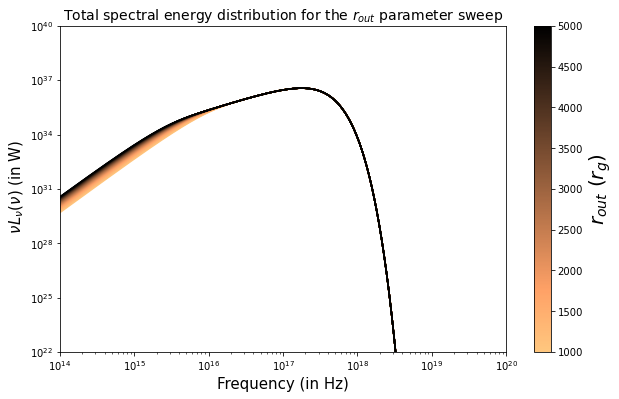

In [25]:
plt.figure(figsize = (10,6))
colours = plt.cm.copper_r(np.linspace(0,1,50))

#plot the total spectral energy distribution for each different radii
for i in range(0,50):
    plt.plot(frequency_array, irradiance_list_rout[i]*frequency_array, c = colours[i], label=r'$\nu L$')

cmap = mpl.cm.copper_r
norm = mpl.colors.Normalize(vmin=rout_frac[0], vmax=rout_frac[-1])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='vertical').set_label(label = r'$r_{out}$ ($r_{g})$', size = 20)

plt.xlabel('Frequency (in Hz)', fontsize = 15)
plt.ylabel(r' $\nu L_{\nu}(\nu)$ (in W)', fontsize = 15)
plt.title(r'Total spectral energy distribution for the $r_{out}$ parameter sweep', fontsize = 14)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22, 1e40)
plt.xlim(1e14, 1e20)
plt.show()

Plotted in the plot above are the total spectral energy distributions for each different $r_{out}$ in the $r_{out}$ parameter sweep. The spectra which have been created with a smaller outer-disk radius are plotted with a lighter colour, as in correspondence with the colour map on the side of the plot. In this parameter sweep, $r_{out}$ has been changed from $1000 r_{g}$ to $5000 r_{g}$ with 50 steps in between. 

Visible in the plot above is that for increasing outer-disk radius, the first 'tail' of the spectrum increases, which is explained simply by the fact that the disk is now larger, so more parts of the disk can radiate. The outer edges of the disk are colder than the inner edges, so $\nu L_{\nu}(\nu)$ will increase for lower frequencies! 

#### Let's take a look at the final parameter sweep for $M_{bh}$

In [26]:
irradiance_list_mbh = []
mbh_frac = np.linspace(5,50,50)

#calculate the irradiance for 50 different inner-disk radii
for i in tqdm(range(0,50)):
    total_irradiance, frequency_array = parameter_sweep(0.05 * 1e-8 * 2 * (mbh_frac[i] * MS) /(year), 6, 1000, (mbh_frac[i] * MS), 0.5)
    irradiance_list_mbh.append(total_irradiance)

100%|██████████| 50/50 [07:00<00:00,  8.40s/it]


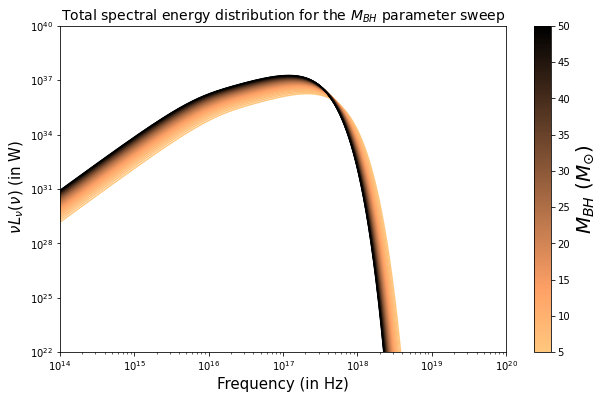

In [27]:
plt.figure(figsize = (10,6))
colours = plt.cm.copper_r(np.linspace(0,1,50))

#plot the total spectral energy distribution for each different radii
for i in range(0,50):
    plt.plot(frequency_array, irradiance_list_mbh[i]*frequency_array, c = colours[i], label=r'$\nu L$')

cmap = mpl.cm.copper_r
norm = mpl.colors.Normalize(vmin=mbh_frac[0], vmax=mbh_frac[-1])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='vertical').set_label(label = r'$M_{BH}$ ($M_{\odot})$', size = 20)

plt.xlabel('Frequency (in Hz)', fontsize = 15)
plt.ylabel(r' $\nu L_{\nu}(\nu)$ (in W)', fontsize = 15)
plt.title(r'Total spectral energy distribution for the $M_{BH}$ parameter sweep', fontsize = 14)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22, 1e40)
plt.xlim(1e14, 1e20)
plt.show()

Plotted in the plot above are the total spectral energy distributions for each different $M_{BH}$ in the $M_{BH}$ parameter sweep. The spectra which have been created with a smaller mass are plotted with a lighter colour, as in correspondence with the colour map on the side of the plot. In this parameter sweep, $M_{BH}$ has been changed from $5 M_{\odot}$ to $50 M_{\odot}$ with 50 steps in between. 

Visible in this plot is that for increasing $M_{BH}$, the peak of the spectrum shifts to *lower* frequencies, however, $\nu L_{\nu}(\nu)$ increases! This is explained by the fact that if $M_{BH}$ increases, the inner-disk radius also must increase, which decreases the temperature range as we saw for the inner-disk radius parameter sweep, and thus shifts the frequency peak to lower frequencies. At the same time, however, the size of our disk is in gravitational radii, which is related to the mass of the black hole. So by increasing the mass of the black hole, the inner disk will become larger, thus enhancing the previously stated shift in the frequency peak, and the outer disk will become larger. This increase will increase the surface area, and thus increase $\nu L_{\nu}(\nu)$! For a increase in $M_{BH}$, we see a decrease in frequency, but an increase in $\nu L_{\nu}(\nu)$.

As mentioned, there are few degeneracies between these parameters. By increasing $\dot{M}$, $\nu L_{\nu}(\nu)$ and $\nu_{peak}$ will increase. By decreasing $r_{in}$, $\nu L_{\nu}(\nu)$ (specifically in the high-energy regime) and $\nu_{peak}$ will increase. By increasing $r_{out}$, $\nu L_{\nu}(\nu)$ (in the low-energy regime) will increase. Lastly, by increasing $M_{BH}$, $\nu L_{\nu}(\nu)$ will increase, where as $\nu_{peak}$ will decrease.

This entire analysis could be done even more rigorously by adding more parameters, for instance by adding the inclination. Adding the inclination to this system would not change much, as this would not affect $\nu_{peak}$ at all. It would only be affecting the surface area from which you see the disk, and thus only affect $\nu L_{\nu}(\nu)$.

During this project, I've had extensive discussions with Mitchell IJzer. Our methods and approach will therefore be akin to each other's. I felt this was only proper to mention. 

I have had a blast with this project, Thanks!

David Konijn, 12484725